In [54]:
import  pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ndcg_score
from sklearn.model_selection import GridSearchCV
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from tqdm.notebook import tqdm
from IPython.display import clear_output
from sklearn.preprocessing import StandardScaler
from collections import Counter
from catboost import CatBoostClassifier, Pool, CatBoostRanker
from copy import deepcopy

In [2]:
train_data = pd.read_csv('/kaggle/input/dataset/train_df.csv')
test_data = pd.read_csv('/kaggle/input/dataset/test_df.csv')

In [3]:
train_data.shape, test_data.shape

((15081, 81), (1529, 81))

### EDA

Определим количество уровней ранжирования и сравним распределение таргета в тестовой и обучающей выборках

In [4]:
print(train_data.target.value_counts())
test_data.target.value_counts()

target
0    14759
1      322
Name: count, dtype: int64


target
0    1495
1      34
Name: count, dtype: int64

In [5]:
print(14759 / 322, 1495 / 34)

45.83540372670807 43.970588235294116


Распределения примерно одинаковы

In [6]:
# Посмотрим наличие пропущенных значений

train_data.isna().any().any(), test_data.isna().any().any()

(False, False)

In [7]:
# Типы признаков
categorical_features = train_data.select_dtypes(exclude=['O']).columns
(~(categorical_features == train_data.columns)).sum()
# Все признаки - вещественные

0

In [15]:
# Удалим константные признаки и за one-hot кодируем признаки, которых небольше 3

for i in range(79):
    feature = 'feature_' + str(i)
    n = train_data[feature].nunique()
    if n == 1:
        train_data = train_data.drop(feature,axis=1)
        test_data = test_data.drop(feature, axis=1)
    elif n <= 3:
        
        train_data = pd.concat([train_data, pd.get_dummies(train_data[feature], dtype = float, prefix=feature, drop_first=True)], axis = 1)
        test_data = pd.concat([test_data, pd.get_dummies(test_data[feature], dtype = float, prefix=feature, drop_first=True)], axis = 1)
        
        train_data = train_data.drop(feature, axis=1)
        test_data = test_data.drop(feature, axis=1)
        
    else:
        continue

In [16]:
train_data.shape, test_data.shape

((15081, 77), (1529, 77))

<Axes: >

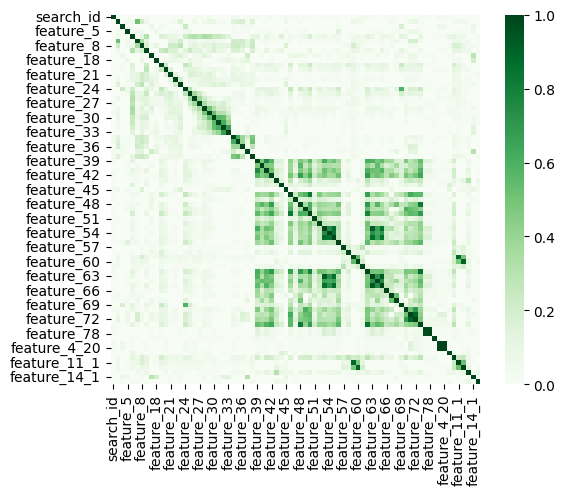

In [17]:
# Посмотрим на линейную корреляцию признаков
corrs = train_data.corr().round(3)
sns.heatmap(corrs, 
           cmap = 'Greens',
           square =True,
           vmin = 0)

По тепловой карте видно, что есть сильно коррелирующие признаки, от которых стоит избавиться.

In [18]:
corrs = train_data.corr().round(3).abs()
corrs_st = corrs.unstack().sort_values(kind='quicksort', ascending=False)

In [19]:
corrs_st = corrs_st[list(filter(lambda x: x[0]!=x[1], list(corrs_st.index)))]
corrs_st[0:10]

feature_3_1   feature_4_20    1.000
feature_4_20  feature_3_1     1.000
feature_77    feature_78      0.968
feature_78    feature_77      0.968
feature_65    feature_63      0.938
feature_63    feature_65      0.938
feature_53    feature_63      0.926
feature_63    feature_53      0.926
feature_12_1  feature_60      0.908
feature_60    feature_12_1    0.908
dtype: float64

In [20]:
# Удалим часть сильно коррелирующих признаков
train_data = train_data.drop(columns=['feature_77', 'feature_63'])
test_data = test_data.drop(columns=['feature_77', 'feature_63'])

#### Вспомогательные функции

In [21]:
def custom_ndcg_score(y_score, mode):
    '''
    Функция считает значение метрики ndcg для каждого из запросов и 
    усредняет полученные результаты
    
    y_score: предсказанные таргеты
    mode: 'train' or 'test' - на каких данных считаем метрику
    '''
    
    tmp = None
    if mode == 'train':
        tmp = train_data.copy()
    else:
        tmp = test_data.copy()
        
    tmp['aux'] = y_score
    unique_search_id = list(tmp.search_id.unique())
    
    scores = []
    for sid in unique_search_id:
        curr = tmp[tmp['search_id'] == sid]
        y_true = list(curr.target.values.reshape(1, -1))
        y_score = list(curr.aux.values.reshape(1, -1))
        if curr.shape[0] != 1:
            scores.append(ndcg_score(y_true, y_score))
        else:
            if y_true[0] == 0:
                scores.append(0)
            else:
                scores.append(int(y_score == y_true))
    
    return np.mean(scores)

In [24]:
# Максимальное значение метрики для обучающей выборки
custom_ndcg_score(train_data['target'], 'train')

0.213

In [25]:
# Максимальное значение метрики для тестовой выборки
custom_ndcg_score(test_data['target'], 'test')

0.23

Для полноценного решения будем использовать несколько подходов к решению задачи ранжирования.

### Идея 1: логистическая регрессия
В качестве начального бейзлайна возьмём модель логистической регрессии над признаками запроса и документа

In [26]:
train_data = train_data.rename(str,axis="columns") 
test_data = test_data.rename(str,axis="columns")    

In [27]:
log_regr = LogisticRegression()
log_regr.fit(train_data.drop('target', axis=1), train_data['target'])
target_pred_train = log_regr.predict(train_data.drop('target', axis=1))
target_pred_test = log_regr.predict(test_data.drop('target', axis=1))

train_ndcg = custom_ndcg_score(target_pred_train, 'train')
test_ndcg = custom_ndcg_score(target_pred_test, 'test')

print(f'NDCG on train: {train_ndcg}')
print(f'NDCG on test: {test_ndcg}')

NDCG on train: 0.09211285185703573
NDCG on test: 0.10083248414572896


### Идея 2: нейронная сеть
Аналогично предыдущему пункту, но в качестве модели предсказывающей таргет возьмём простую нейронную сеть в предположении, что она сможет выучить более сложные зависимости. Я понимаю, что это плохой вариант так как даже при самой простой архитектуре мы скорее всего получим переобучение, но всё же можно попробовать.

In [28]:
X_train = train_data.drop(columns=['target', 'search_id']).values
y_train = train_data['target'].values
X_test = test_data.drop(columns = ['target', 'search_id']).values
y_test = test_data['target'].values

In [29]:
X_train = train_data.drop('target', axis=1).values
y_train = train_data['target'].values
X_test = test_data.drop('target', axis=1).values
y_test = test_data['target'].values

In [30]:
class CustomDataset(Dataset):
    
    def __init__(self, X, y):
        
        super().__init__()
        self.X = X
        self.y = y
        
    def __getitem__(self , item):
        
        return self.X[item], self.y[item]
    
    def __len__(self):
        
        return self.X.shape[0]

In [31]:
train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_test, y_test)

In [32]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, num_workers=4)

In [33]:
X_train_ts = torch.tensor(X_train, dtype=torch.float32)
y_train_ts = torch.tensor(y_train, dtype=torch.int64)
X_test_ts = torch.tensor(X_test, dtype=torch.float32)
y_test_ts = torch.tensor(y_test, dtype=torch.int64)

In [34]:
# Метрика на рандомных весах нейронной сети
net = nn.Sequential(
    nn.Linear(74,  32),
    nn.BatchNorm1d(32),
    nn.LeakyReLU(0.1),
    nn.Linear(32, 2)
)

y_pred = net(X_train_ts).argmax(dim=-1)
custom_ndcg_score(net(X_train_ts).argmax(dim=-1).detach().numpy().reshape(-1), 'train')

0.09311285185703573

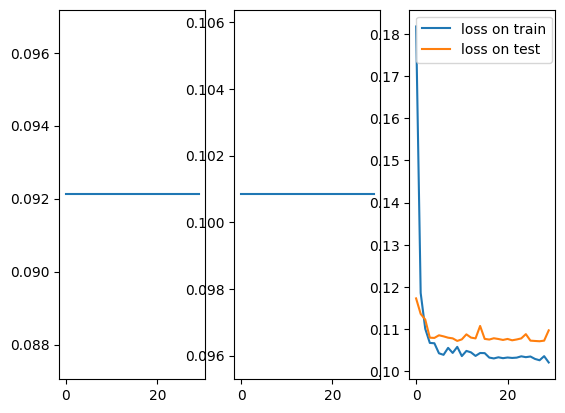

In [35]:
net = nn.Sequential(
    nn.Linear(74,  32),
    nn.BatchNorm1d(32),
    nn.LeakyReLU(0.1),
    nn.Linear(32, 2)
)

num_epochs = 30
opt = torch.optim.AdamW(net.parameters())
loss_fn = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=num_epochs)

ndcg_train = []
ndcg_test = []
train_losses = []
test_losses = []
for i in range(num_epochs):
    
    sum_loss = 0
    for x, y in tqdm(train_loader, desc='Train'):
        
        y_pred = net(x.to(torch.float32))
        loss = loss_fn(y_pred, y)
        sum_loss += loss.item()
        loss.backward()
        opt.step()
        opt.zero_grad()
    
    scheduler.step()
    
    train_losses.append(sum_loss / len(train_loader))
    with torch.no_grad():
        y_pred = net(X_train_ts).argmax(dim=-1).detach().numpy().reshape(-1)
        ndcg_train.append(custom_ndcg_score(y_pred, 'train'))
        
        logits = net(X_test_ts)
        test_losses.append(loss_fn(logits, y_test_ts).item())
        y_pred = net(X_test_ts).argmax(dim=-1).detach().numpy().reshape(-1)
        ndcg_test.append(custom_ndcg_score(y_pred, 'test'))
        
    clear_output()
    fig, ax = plt.subplots(1, 3)
    ax[0].plot(range(i + 1), ndcg_train, label = 'metric on train')
    ax[1].plot(range(i + 1), ndcg_test, label = 'metric on test')
    ax[2].plot(range(i + 1), train_losses, label = 'loss on train')
    ax[2].plot(range(i + 1), test_losses, label = 'loss on test')
    plt.legend()
    plt.show()

Да, как и ожидалось, мы получаем небольшое перобучение ну и решение данной задачи как задачи классификации не даёт абсолютно никакого прироста к метрике(.

### Идея 3: item2item подход
Суть в том, что мы для каждого объекта будем иметь множество похожих с ним (похожие будут из обучающей выборки) и на основании таргетов похожих будем делать предсказание для текущего item'a.

Недостатки подхода: мы никак не учитываем информацию о конкретном запросе, но её учесть мы априори не можем, так как id-шники поисковых запросов в тесте и трейне совершенно разные, поэтому работаем в предположении что схожие объекты в большинстве случаев либо нравятся либо не нравятся пользователям (я понимаю что это предположение может быть неверным, но попробуем всё же).

In [36]:
df_train = train_data.drop(columns=['search_id', 'target'])
df_test = test_data.drop(columns=['search_id', 'target'])

In [41]:
# Преобразуем признаки, чтобы максимальное значение скалярного произведения было равным 1(для простоты)

# Стандартизуем признаки
scaler = StandardScaler()
df_train_scaled = scaler.fit_transform(df_train)
df_test_scaled = scaler.transform(df_test)

# Приводим к единичной норме
df_train_scaled = np.apply_along_axis(lambda x : x / np.linalg.norm(x), 1, df_train_scaled)
df_test_scaled = np.apply_along_axis(lambda x : x / np.linalg.norm(x), 1, df_test_scaled)

In [50]:
def get_prediction(item, threshold = 0.8):
    
    '''
    Функция определяет схожие объекты из обучающей выборки для объекта из тестовой.
    И на основе таргетов к этим объектам делает предсказание - выбирая самый частый таргет к близким объектам
    
    - item: индекс объекта из теста
    - threshold: минимально допустимое значение близости
    '''
    
    curr_item = df_test_scaled[item]
    dists = df_train_scaled @ curr_item
    targets = list(train_data[dists > threshold].target.values)
    if len(targets) == 0:
        most_common = 0
    else:
        most_common = Counter(targets).most_common(1)[0][0]
    return most_common

In [51]:
# Тестирование функции get_prediction
y_pred = []

for i in range(test_data.shape[0]):
    y_pred.append(get_prediction(i))
    
custom_ndcg_score(y_pred, 'test')

0.10041426187938068

In [52]:
# Более продвинутая версия функции get_prediction
# Взвешиваем вклад каждого объекта на основе степени схожести

def get_prediction_mod(item, threshold = 0.8):
    
    '''
    Функция определяет схожие объекты из обучающей выборки для объекта из тестовой.
    
    - item: индекс объекта из теста
    - threshold: минимально допустимое значение близости
    '''
    
    curr_item = df_test_scaled[item]
    dists = df_train_scaled @ curr_item
    dists_series = pd.Series(list(dists))
    targets = train_data.target * dists_series
    targets = targets[dists > threshold]
    
    res = np.mean(targets.values)
    res /= dists_series[dists > threshold].values.sum()
    
    return [int(res>0.5),train_data[dists > threshold]]

In [55]:
# Тестирование функции get_prediction_mod
y_pred = []

for i in range(test_data.shape[0]):
    y_pred.append(get_prediction_mod(i)[0])
    
print(custom_ndcg_score(y_pred, 'test'))
y_pred = np.array(y_pred)

/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.10083248414572896


В принципе можно продолжать развивать эту идею, но поперберав различные гиперпараметры для threshold я не получил никакого значимого прироста к метрики, поэтому кажется, что стоит воспользоваться специализированными фреймворками.

### Идея 4: CatBoost 

Сначала начнём с простейшего - pointwise подхода, оптимизируем rmse предсказывая скор объекта.

In [40]:
train = Pool(
    data=X_train,
    label=y_train,
    group_id=train_data['search_id'].values
)

test = Pool(
    data=X_test,
    label=y_test,
    group_id=test_data['search_id'].values
)

default_parameters = {
    'iterations' : 1500,
    'eval_metric' : 'NDCG', # Указываем целевую метрики задачи в качестве валидационной
    'custom_metric' : ['NDCG'],
    'use_best_model' : True,
    'verbose': 500,
    'random_seed' : 0,

    # Параметры для регуляризации и ускорения
    'colsample_bylevel' : 0.098,
    'subsample' : 0.95,
    'min_data_in_leaf': 243,
    'random_strength' : 1,
    
    # Параметры скорения
    'thread_count': -1,
    'bootstrap_type' : 'Bernoulli',
    
    'random_seed' : 42,
}

parameters = {}

In [57]:
def fit_model(loss_function, train_pool=train, test_pool=test):
    parameters = deepcopy(default_parameters)
    parameters['loss_function'] = loss_function
    parameters['train_dir'] = loss_function
    
    model = CatBoostRanker(**parameters)
    model.fit(train_pool, eval_set=test_pool, plot=True)
    
    return model

In [145]:
default_parameters = {
    'iterations' : 1500,
    'eval_metric' : 'NDCG', # Указываем целевую метрики задачи в качестве валидационной
    'custom_metric' : ['NDCG'],
    'use_best_model' : True,
    'verbose': 500,
    'random_seed' : 0,

    # Параметры для регуляризации и ускорения
    'colsample_bylevel' : 0.098,
    'subsample' : 0.95,
    'min_data_in_leaf': 243,
    'random_strength' : 1,
    
    # Параметры скорения
    'thread_count': -1,
    'bootstrap_type' : 'Bernoulli',
    
    'random_seed' : 42,
}


default_parameters['iterations'] = 1000
#default_parameters['learning_rate'] = 1
model = fit_model('RMSE')
custom_ndcg_score(model.predict(X_test), 'test')

/opt/conda/lib/python3.10/site-packages/catboost/core.py:6219: RuntimeWarning: Regression loss ('RMSE') ignores an important ranking parameter 'group_id'
  warnings.warn("Regression loss ('{}') ignores an important ranking parameter 'group_id'".format(loss_function), RuntimeWarning)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.077967
0:	test: 0.8719120	best: 0.8719120 (0)	total: 5.18ms	remaining: 5.17s
500:	test: 0.9266927	best: 0.9268990 (498)	total: 2.47s	remaining: 2.46s
999:	test: 0.9267566	best: 0.9318176 (643)	total: 4.96s	remaining: 0us

bestTest = 0.9318175917
bestIteration = 643

Shrink model to first 644 iterations.


0.15181759170965192

Получили более хорошее значение метрики по сравнению с предыдущими подходами. Параметры натюнил как мог)

Теперь попробуем воспользоваться pairwise-подходом, минимизируя loglikelihood (метод основан на парном сравнении объектов, вычисляя вероятность того, что один из них более релевантен чем другой через сигмоиду разности предсказаний модели).

In [141]:
default_parameters['iterations'] = 1000
model2 = fit_model('PairLogit')
custom_ndcg_score(model2.predict(X_test), 'test')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.8920969	best: 0.8920969 (0)	total: 17.5ms	remaining: 17.5s
500:	test: 0.8922806	best: 0.9094462 (211)	total: 9.74s	remaining: 9.71s
999:	test: 0.8903646	best: 0.9094462 (211)	total: 19.7s	remaining: 0us

bestTest = 0.9094461639
bestIteration = 211

Shrink model to first 212 iterations.


0.12944616389793207

Значение метрики к сожалению сильно упало по сравнению с предыдущим методом.

Возьмём теперь в качестве лосса - функцию YetiRank

In [152]:
default_parameters = {
    'iterations' : 1000,
    'eval_metric' : 'NDCG', # Указываем целевую метрики задачи в качестве валидационной
    'custom_metric' : ['NDCG'],
    'use_best_model' : True,
    'verbose': 500,
    'random_seed' : 0,
    
    # Параметры для регуляризации и ускорения
    'colsample_bylevel' : 0.098,
    'subsample' : 0.95,
    'min_data_in_leaf': 243,
}

default_parameters['iterations'] = 1500
model3 = fit_model('YetiRank')
custom_ndcg_score(model3.predict(X_test), 'test')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.8760420	best: 0.8760420 (0)	total: 14ms	remaining: 21s
500:	test: 0.9151629	best: 0.9419908 (81)	total: 6.6s	remaining: 13.2s
1000:	test: 0.9140763	best: 0.9419908 (81)	total: 13.3s	remaining: 6.63s
1499:	test: 0.9078649	best: 0.9419908 (81)	total: 20.7s	remaining: 0us

bestTest = 0.9419908492
bestIteration = 81

Shrink model to first 82 iterations.


0.1619908491995531

Максимальное полученное значение метрики - 0.162/0.23

In [58]:
default_parameters = {
    'iterations' : 1000,
    'eval_metric' : 'NDCG', # Указываем целевую метрики задачи в качестве валидационной
    'custom_metric' : ['NDCG'],
    'use_best_model' : True,
    'verbose': 500,
    'random_seed' : 0,
    
    # Параметры для регуляризации и ускорения
    'colsample_bylevel' : 0.098,
    'subsample' : 0.95,
    'min_data_in_leaf': 243,
}

model4 = fit_model('YetiRankPairwise')
custom_ndcg_score(model4.predict(X_test), 'test')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.8815785	best: 0.8815785 (0)	total: 97.9ms	remaining: 1m 37s
500:	test: 0.9230674	best: 0.9280651 (104)	total: 12.5s	remaining: 12.5s
999:	test: 0.9163760	best: 0.9280651 (104)	total: 25.5s	remaining: 0us

bestTest = 0.9280650907
bestIteration = 104

Shrink model to first 105 iterations.


0.14810303379672946

# Итог
# Я получил - 0.162
# Максимум можно было получить - 0.23